In [27]:
import glob
from pathlib import Path

import gc

import os

import torch

from rastervision.core.data import ClassConfig
from rastervision.core.data import SemanticSegmentationLabels, SemanticSegmentationDiscreteLabels
from rastervision.core.data import RasterioSource, MinMaxTransformer
from rastervision.core.data.label_store.semantic_segmentation_label_store_config import PolygonVectorOutputConfig

from rastervision.pytorch_learner import SemanticSegmentationLearner
from rastervision.pytorch_learner import SolverConfig
from rastervision.pytorch_learner import SemanticSegmentationLearnerConfig
from rastervision.pytorch_learner import SemanticSegmentationSlidingWindowGeoDataset
from rastervision.pytorch_learner import SemanticSegmentationGeoDataConfig

In [28]:
# cantidad de iteraciones qeu fueron hechas en train
n_epochs = 100

In [29]:
# import gdown

# model_folder = "/content/drive/MyDrive/IA/basurales/modelo_pre_entrenado/"
model_folder = "./data/models/"
# !mkdir -p $model_folder
# model_url = "https://drive.google.com/file/d/1DdjZBPrMNsCp35tZSk7u-EgnIYe0wDu9/view?usp=sharing"
model_path = f"./data/models/bundle_{n_epochs}/model-bundle.zip"

# gdown.download(model_url, model_path, fuzzy=True)

In [30]:
class_config = ClassConfig(
    names=['background', 'viviendas precarias'],
    colors=['lightgray', 'darkred'],
    null_class='background')
class_config.ensure_null_class()


window_size = 64

model = torch.hub.load(
    'AdeelH/pytorch-fpn:0.3',
    'make_fpn_resnet',
    name='resnet18',
    fpn_type='panoptic',
    num_classes=len(class_config),
    fpn_channels=128,
    in_channels=3,
    out_size=(window_size, window_size),
    pretrained=True)


learner = SemanticSegmentationLearner.from_model_bundle(model_bundle_uri=model_path, model=model, output_dir=model_folder, training=False)

Using cache found in C:\Users\oltie/.cache\torch\hub\AdeelH_pytorch-fpn_0.3
2024-10-09 11:24:56:rastervision.pytorch_learner.learner: INFO - Loading learner from bundle ./data/models/bundle_100/model-bundle.zip.
2024-10-09 11:24:56:rastervision.pytorch_learner.learner: INFO - Unzipping model-bundle to C:\Users\oltie\AppData\Local\Temp\tmpypc17zu1\model-bundle
2024-10-09 11:24:57:rastervision.pytorch_learner.learner: INFO - Loading model weights from: C:\Users\oltie\AppData\Local\Temp\tmpypc17zu1\model-bundle\model.pth


In [31]:
test_images_uri ="./data/test/img/2021.tif"
test_labels_uri = "./data/test/labels/barrios_3dfeb_lamtz.geojson"
AoI_file_dest_uri = "./data/aoi/AoI_3dfeb_LaMtz.geojson"

In [32]:
window_size = 64
save_dir = f"./data/results/preds_{n_epochs}/"

img_raster_source = RasterioSource(test_images_uri, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

pred_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
    class_config=class_config,
    image_uri=test_images_uri,
    image_raster_source_kw=dict(allow_streaming=True),
    aoi_uri=AoI_file_dest_uri,
    size=window_size,
    stride=window_size)

predictions = learner.predict_dataset(
    pred_ds,
    raw_out=True,
    numpy_out=True,
    predict_kw=dict(out_shape=(window_size, window_size)),
    progress_bar=True)

pred_labels = SemanticSegmentationLabels.from_predictions(
    pred_ds.windows,
    predictions,
    smooth=True,
    extent=pred_ds.scene.extent,
    num_classes=len(class_config))

# # liberamos memoria
# del pred_ds
# gc.collect()

# Guardar predicciones
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # set to False to skip writing `labels.tif`
    discrete_output=False,
    # set to False to skip writing `scores.tif`
    smooth_output=False,
    # set to True to quantize floating point score values to uint8 in scores.tif to reduce file size
    smooth_as_uint8=True,
    # vector outputs are now always written to <pred root URI>/vector_outputs/class-<i>-<class name>.json
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

# # renombramos el archivo con la predicción
# !mv {save_dir + "vector_output/class-1-basural.json"} {save_dir + "vector_output/" + Path(raster_file).stem + "_prediction.json"}

# # limpieza final
# del predictions
# del pred_labels
# gc.collect()

Predicting: 100%|██████████| 754/754 [00:06<00:00, 118.35it/s]
2024-10-09 11:25:06:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.91s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [33]:
scores = pred_labels.get_score_arr(pred_labels.extent)

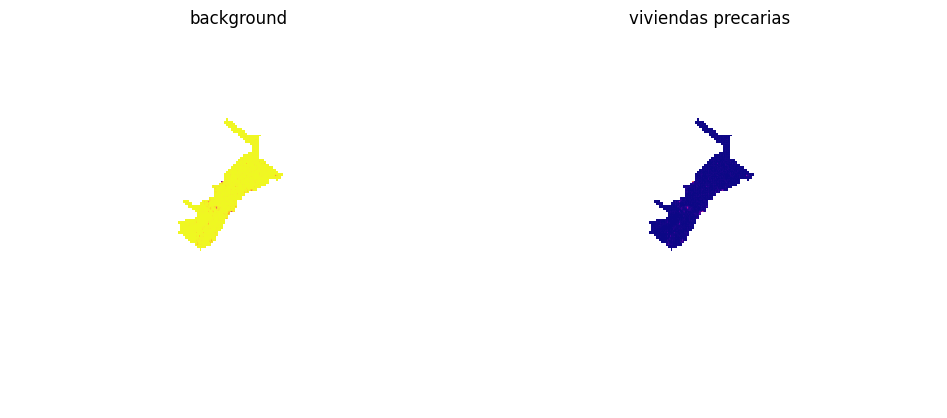

In [34]:
from matplotlib import pyplot as plt

scores_vivienda = scores[1]
scores_background = scores[0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
fig.tight_layout(w_pad=-2)
ax1.imshow(scores_background, cmap='plasma')
ax1.axis('off')
ax1.set_title('background')
ax2.imshow(scores_vivienda, cmap='plasma')
ax2.axis('off')
ax2.set_title('viviendas precarias')
plt.show()

In [35]:
pred_labels.save(
    uri=save_dir,
    crs_transformer=img_raster_source.crs_transformer,
    class_config=class_config,
    # discrete_output=False,
    # smooth_output=False,
    smooth_as_uint8=True,
    vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
)

Saving pixel scores: 100%|██████████| 20/20 [00:04<00:00,  4.45it/s]
2024-10-09 11:25:35:rastervision.core.data.label_store.semantic_segmentation_label_store: INFO - Writing vector outputs to disk.
Vectorizing predictions: 100%|██████████| 1/1 [00:04<00:00,  4.52s/it, class_id=1, denoise=8, threshold=None, type_hint=polygon_vector_output]


In [36]:
from rastervision.core.data.utils import make_ss_scene

scene = make_ss_scene(
    class_config=class_config,
    image_uri=test_images_uri,
    label_vector_uri=test_labels_uri,
    label_vector_default_class_id=class_config.get_class_id('viviendas precarias'),
    label_raster_source_kw=dict(
        background_class_id=class_config.get_class_id('background')),
    image_raster_source_kw=dict(allow_streaming=True))

gt_labels = scene.label_source.get_labels()

In [37]:
from rastervision.core.evaluation import SemanticSegmentationEvaluator

evaluator = SemanticSegmentationEvaluator(class_config)

evaluation = evaluator.evaluate_predictions(
    ground_truth=gt_labels, predictions=pred_labels)

Computing metrics: 100%|██████████| 1/1 [00:33<00:00, 33.61s/it]


In [38]:
evaluation.class_to_eval_item[0]

{'class_id': 0,
 'class_name': 'background',
 'conf_mat': [[527.0, 291834.0], [0.0, 122538759.0]],
 'conf_mat_dict': {'FN': 0.0, 'FP': 291834.0, 'TN': 527.0, 'TP': 122538759.0},
 'conf_mat_frac': [[4.290443659554679e-06, 0.0023758962712381033],
                   [0.0, 0.9976198132851023]],
 'conf_mat_frac_dict': {'FN': 0.0,
                        'FP': 0.0023758962712381033,
                        'TN': 4.290443659554679e-06,
                        'TP': 0.9976198132851023},
 'count_error': 291834.0,
 'gt_count': 122538759.0,
 'metrics': {'f1': 0.9988106338561794,
             'precision': 0.9976240935350691,
             'recall': 1.0,
             'sensitivity': 1.0,
             'specificity': 0.001802566005725798},
 'pred_count': 122830593.0,
 'relative_frequency': 0.9976198132851023}

In [39]:
evaluation.class_to_eval_item[1]

{'class_id': 1,
 'class_name': 'viviendas precarias',
 'conf_mat': [[122538759.0, 0.0], [291834.0, 527.0]],
 'conf_mat_dict': {'FN': 291834.0, 'FP': 0.0, 'TN': 122538759.0, 'TP': 527.0},
 'conf_mat_frac': [[0.9976198132851023, 0.0],
                   [0.0023758962712381033, 4.290443659554679e-06]],
 'conf_mat_frac_dict': {'FN': 0.0023758962712381033,
                        'FP': 0.0,
                        'TN': 0.9976198132851023,
                        'TP': 4.290443659554679e-06},
 'count_error': 291834.0,
 'gt_count': 292361.0,
 'metrics': {'f1': 0.003598645215918713,
             'precision': 1.0,
             'recall': 0.001802566005725798,
             'sensitivity': 0.001802566005725798,
             'specificity': 1.0},
 'pred_count': 527.0,
 'relative_frequency': 0.002380186714897658}

In [40]:
evaluation.save(f'data/results/eval_{n_epochs}.json')

### BASURALES_____________________________________________________________________________________________________________

In [ ]:
#def generate_prediction_polygons(raster_file, aoi_uri, class_config, learner, save_dir):
def generate_prediction_polygons(raster_file, class_config, learner, save_dir):

    print(f'Processing {raster_file}...')

    img_raster_source = RasterioSource(raster_file, allow_streaming=True, raster_transformers=[MinMaxTransformer()])

    pred_ds = SemanticSegmentationSlidingWindowGeoDataset.from_uris(
        class_config=class_config,
        image_uri=raster_file,
        image_raster_source_kw=dict(allow_streaming=True),
        #aoi_uri=aoi_uri,
        size=window_size,
        stride=window_size)

    predictions = learner.predict_dataset(
        pred_ds,
        raw_out=True,
        numpy_out=True,
        predict_kw=dict(out_shape=(window_size, window_size)),
        progress_bar=True)

    pred_labels = SemanticSegmentationLabels.from_predictions(
        pred_ds.windows,
        predictions,
        smooth=True,
        extent=pred_ds.scene.extent,
        num_classes=len(class_config))

    # liberamos memoria
    del pred_ds
    gc.collect()

    # Guardar predicciones
    pred_labels.save(
        uri=save_dir,
        crs_transformer=img_raster_source.crs_transformer,
        class_config=class_config,
        # set to False to skip writing `labels.tif`
        discrete_output=False,
        # set to False to skip writing `scores.tif`
        smooth_output=False,
        # set to True to quantize floating point score values to uint8 in scores.tif to reduce file size
        smooth_as_uint8=True,
        # vector outputs are now always written to <pred root URI>/vector_outputs/class-<i>-<class name>.json
        vector_outputs=[PolygonVectorOutputConfig(class_id=1)]
    )

    # renombramos el archivo con la predicción
    !mv {save_dir + "vector_output/class-1-basural.json"} {save_dir + "vector_output/" + Path(raster_file).stem + "_prediction.json"}

    # limpieza final
    del predictions
    del pred_labels
    gc.collect()

    print(f'Done: {raster_file}\n'
    )

In [ ]:
save_dir = "/tmp/predicciones/"
!mkdir -p $save_dir

#aoi_uri = AoI_file_dest

for raster_file in raster_files:
    #generate_prediction_polygons(raster_file, aoi_uri, class_config, learner, save_dir)
    generate_prediction_polygons(raster_file, class_config, learner, save_dir)

In [ ]:
predictions_dest = "/content/drive/MyDrive/IA/basurales/predicciones/"
!mkdir -p $predictions_dest

import geopandas as gpd

partial_results = glob.glob(save_dir + "vector_output/*.json")

results = gpd.GeoDataFrame()

for file in partial_results:
    results = gpd.GeoDataFrame(gpd.pd.concat([results, gpd.read_file(file)]))

results.to_file(predictions_dest + "predicciones.geojson", driver="GeoJSON")

In [ ]:
!ls {predictions_dest + "predicciones.geojson"}